### Problem: Congestion detection

Deep Learning is awesome, it has given wings to computer vision and object
detection/classification. We can even identify traffic patterns and count/estimate speed.
We have to now detect congestion on the road.

The simple process should be to get a video processing module but video streaming and handling are a time and computataional complex task, so we disassociate the video into frames, which is easy to handle and also a task that can be handled on the edge. 

I chose DETR because they're fast and effecient and have a very good AP score and also because as I'm an avid AI journal reader, I had read about the SOTA in object detection just a couple of months ago and DETR had come into the picture.

#### DETR (DEtection TRansformer)

Replacing the full complex hand-crafted object detection pipeline with a Transformer, and match Faster R-CNN with a ResNet-50, obtaining 42 AP on COCO using half the computation power (FLOPs) and the same number of parameters.

Unlike traditional computer vision techniques, DETR approaches object detection as a direct set prediction problem. It consists of a set-based global loss, which forces unique predictions via bipartite matching, and a Transformer encoder-decoder architecture. Given a fixed small set of learned object queries, DETR reasons about the relations of the objects and the global image context to directly output the final set of predictions in parallel. Due to this parallel nature, DETR is very fast and efficient.

In [1]:
import cv2
import torch

import matplotlib.pyplot as plt
import torchvision.transforms as T

from PIL import Image
from IPython.display import clear_output
from google.colab.patches import cv2_imshow

In [2]:
vidcap = cv2.VideoCapture('drive/My Drive/sample1.asf')

In [3]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [4]:
# If detected class is any of the one present, count increases
detect_classes = ['car', 'motorcycle', 'bus', 'truck']

### Preprocessing

Get torch transformations so as to preprocess the image for the model

Transformations are in sequence:
- Resize image to (800, 800)
- Dump PIL array to torchTensor
- Normalize channels using given std dev and means

In [5]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
# Load DETR model from torch hub
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained = True).to('cuda')
model.eval()

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
       

In [7]:
fps = vidcap.get(cv2.CAP_PROP_FPS) 

Congested at 123.8 seconds into the video


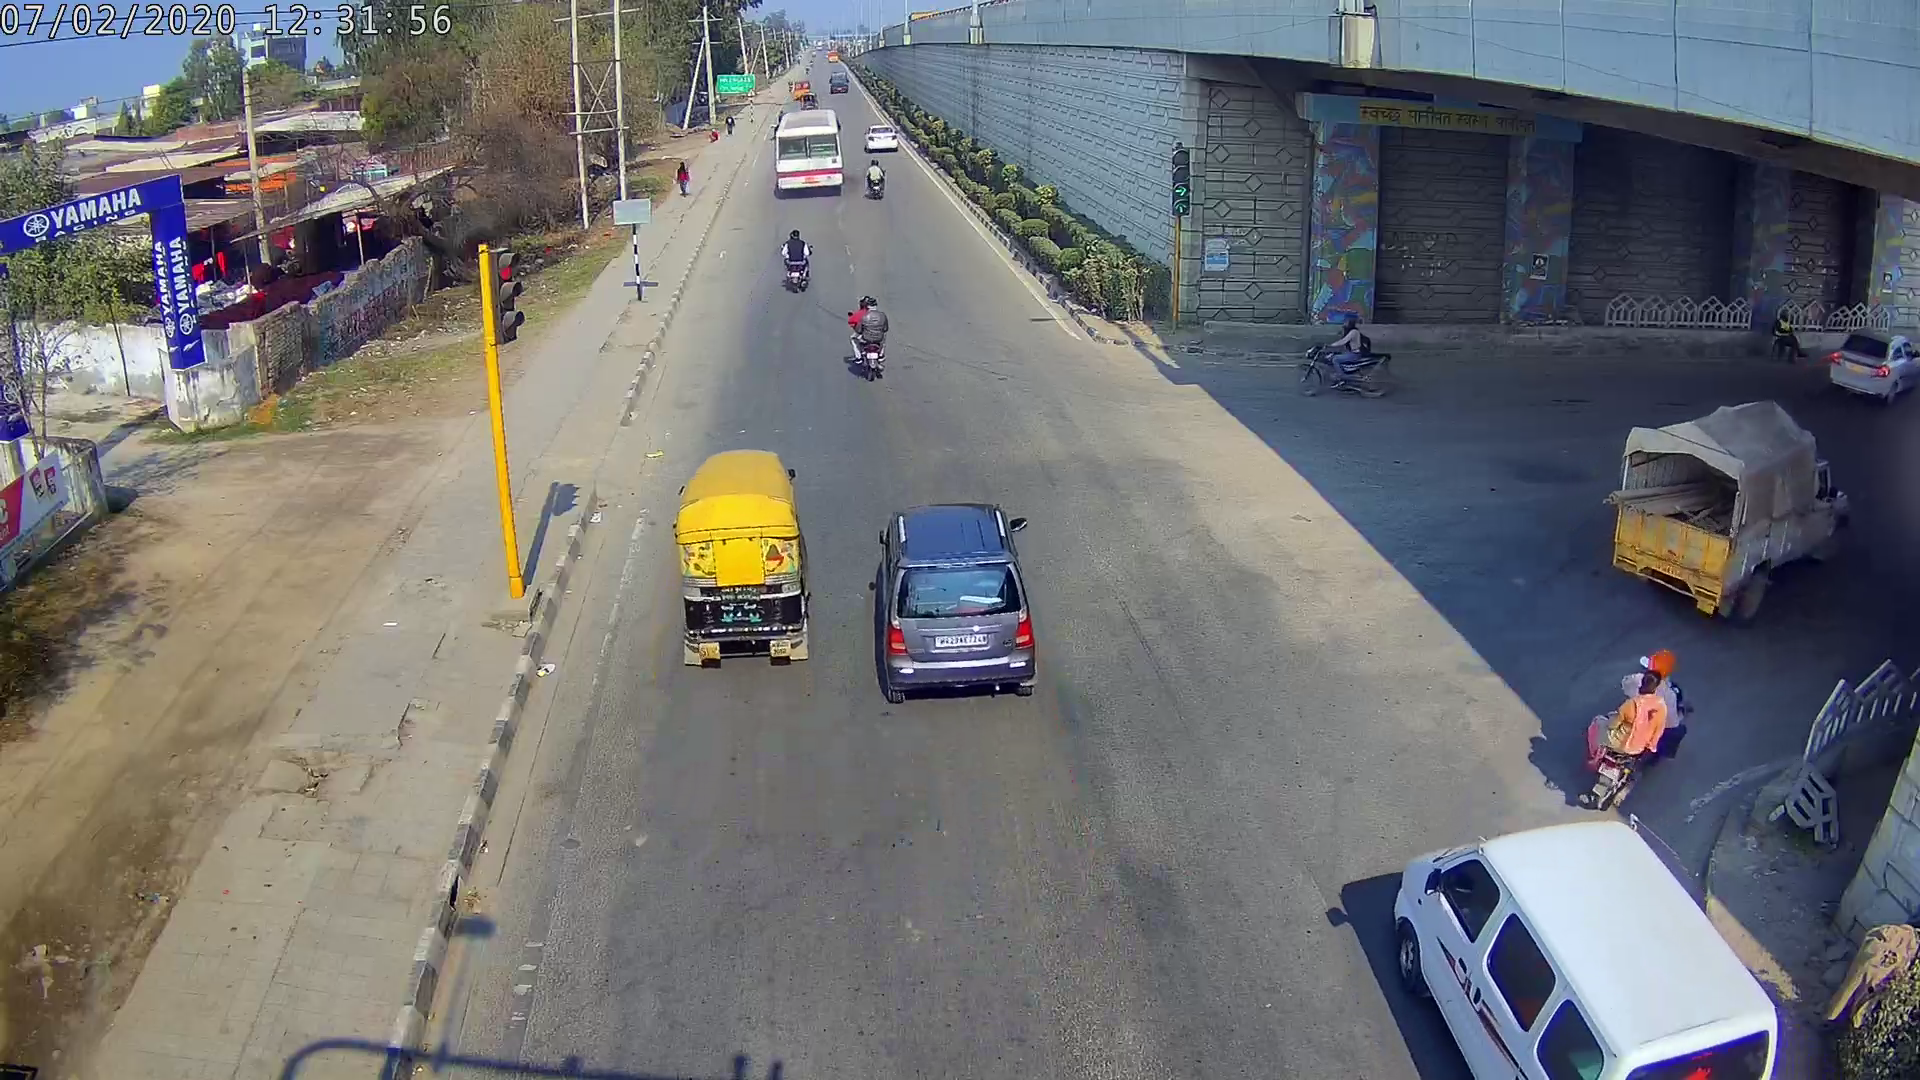

In [8]:
success = True
i = 1
while success:
  success, frame = vidcap.read()
  frame_tensor = transform(Image.fromarray(frame.astype('uint8'), 'RGB')).unsqueeze(0).to('cuda') 
  # dump tensor onto gpu, after transforming from a PIL object
  outputs = model(frame_tensor)
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1] # get softmax of output logits, on the last axis
  keep = probas.max(-1).values > 0.75 # keep all indexes which have more than 75% probs among logits
  count = 0
  for p in probas[keep]:
    label = p.argmax() # get index of most probable class
    if CLASSES[label] in detect_classes:
      count += 1
  if(count > 20): # cond: if more than 20 vehicles detected print output and break from loop
    clear_output()
    print('Congested at ' + str(i/fps) + ' seconds into the video')
    cv2_imshow(frame)
    success = False
  i += 1